<h1 style="font-size:3rem;color:orange;">Eleições 2022 - Análise dos Votos Para Presidente</h1>

AVISO de Licença de Uso e Reserva de Direitos Autorais BSD 3 Clause. Copyright (c) 2022 por John Robson <john.robson@msn.com> (PIX)

Todo o Código fonte e demais arquivos estão sobre a Licença BSD 3 Clause. Modificações, Redistribuição, uso Comercial são permitidos, sempre informando
esse aviso de direitos autorais e o repositório oficial: https://github.com/JohnRobson/Eleicoes2022

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import timeit
import ast
from sqlalchemy import select, func

import matplotlib.pylab as plt
%matplotlib inline

from IPython.display import Markdown, display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>div.output_scroll { height: 100%; }</style>"))

from bd_urnas import engine, Base, Session, Urnas
from src_config import federacao, estados_federacao
session = Session()

def printmd(string): # convert markdown para HTML
    display(Markdown(string))

In [3]:
# Importando Banco de Dados para Python Pandas Dataframe
bd = pd.read_sql_query('SELECT id, turno, regiao, estado, municipio, zona, local, secao, vPresA22, vPresB13, vPresNulo, vPresBranco, vGovA,\
vGovB, vGovNulo, vGovBranco, qEleitAptos, qComparecimento, qEleitLibCodigo, qEleitBiometrico, modelUrna, arquivoBU FROM urnas', session.bind)

# Criação de Colunas Extas para Análises
bd['vPresTotal'] = bd['vPresA22'] + bd['vPresB13'] # total votos presidente
bd['vGovTotal'] = bd['vGovA'] + bd['vGovB'] # coluna total votos governador

In [4]:
turno = 2 # turno analisado
bdt = bd[bd['turno'] == turno]

printmd(f'Modelos de Urnas Usadas nas Eleições, quantidade de Votos Válidos por modelo e Percentual de Votos Recebido por cada Candidato a Presidente:')

# conta a quantidade de urnas de cada modelo
modelos_urna = bdt.groupby(['modelUrna'])['modelUrna'].count()

# conta o total de votos recebido em cada modelo
total_votos_modelo = bdt.groupby('modelUrna')[['vPresA22', 'vPresB13', 'vPresTotal']].sum()

# calcula o percentual de votos que cada modelo de urna recebeu no país
perc_votos_modelo = total_votos_modelo['vPresTotal'].div(total_votos_modelo['vPresTotal'].sum()).multiply(100).round(2)

modelos_urna = pd.concat([modelos_urna, perc_votos_modelo], axis=1) # junta as columnas de quantidade e percentual de votos por modelo
modelos_urna.rename(columns={'modelUrna': 'Qtd Urnas', 'vPresTotal': 'Perc Total Votos'}, inplace=True) # renomeia as colunas

#calcula o percentual de votos de cada presidente de acoardo com o model de urna
total_votos_modelo['Perc Bolsonaro'] = total_votos_modelo['vPresA22'].div(total_votos_modelo['vPresTotal']).multiply(100).round(2)
total_votos_modelo['Perc Lula'] = total_votos_modelo['vPresB13'].div(total_votos_modelo['vPresTotal']).multiply(100).round(2)

# calcula os votos a favor do candidato Lula
total_votos_modelo['Perc Votos Favor Lula'] = total_votos_modelo['Perc Lula'].div(total_votos_modelo['Perc Bolsonaro']).sub(1).multiply(100).round(2)

tabela_modelos_urna = pd.concat([modelos_urna, total_votos_modelo], axis=1)
tabela_modelos_urna
print('obs.: o código "UE0000" foi escolhido para os BUs sem o Log de urna, como foram uma quantidade insignificante, será desconsiderado nos próximos cálculos. (foram 57 urnas no primeiro turno e 5 no segundo turno.')

printmd('O que se destaca nesses dados é o fato de **haver uma diferença de +4.21% até +16.64% por cento de votos a favor do candidato Lula (e contra o candidato Bolsonaro) nas urnas de modelos anteriores a 2020.** Essa constatação merece uma melhor análise.')

Modelos de Urnas Usadas nas Eleições, quantidade de Votos Válidos por modelo e Percentual de Votos Recebido por cada Candidato a Presidente:

,Qtd Urnas,Perc Total Votos,vPresA22,vPresB13,vPresTotal,Perc Bolsonaro,Perc Lula,Perc Votos Favor Lula
modelUrna,,,,,,,,
UE0000,5,0.00,221,836,1057,20.91,79.09,278.24
UE2009,48245,9.86,5722673,5963741,11686414,48.97,51.03,4.21
UE2010,93790,18.94,10379046,12069548,22448594,46.23,53.77,16.31
UE2011,26889,5.38,2943287,3432852,6376139,46.16,53.84,16.64
UE2013,24672,4.94,2857302,3001068,5858370,48.77,51.23,5.04
UE2015,85735,17.61,10114104,10766404,20880508,48.44,51.56,6.44
UE2020,192691,43.27,26189721,25111550,51301271,51.05,48.95,-4.11


obs.: o código "UE0000" foi escolhido para os BUs sem o Log de urna, como foram uma quantidade insignificante, será desconsiderado nos próximos cálculos. (foram 57 urnas no primeiro turno e 5 no segundo turno.


O que se destaca nesses dados é o fato de **haver uma diferença de +4.21% até +16.64% por cento de votos a favor do candidato Lula (e contra o candidato Bolsonaro) nas urnas de modelos anteriores a 2020.** Essa constatação merece uma melhor análise.

In [5]:
bdt = bdt.drop(bdt[bdt['modelUrna'] == 'UE0000'].index) # remove as urnas sem identificação de modelo (57 no 1o turno e 5 no 2o turno)

In [6]:
printmd(f'Analisando a distribuição de cada modelo de urna pelas regiões do Brasil:')

# para cada região do país, conta o número de urnas
modelos_urna = bdt.groupby(['regiao', 'modelUrna'])['modelUrna'].count().reset_index(name='qtd')
modelos_urna = modelos_urna.pivot(index='regiao', columns='modelUrna', values='qtd').fillna(0).astype(int) # reorganiza tabela

total_urnas = modelos_urna.sum(axis=1) # calcula o total de urnas para cada região
modelos_urna_pct = modelos_urna.div(total_urnas, axis=0).multiply(100).round(2)
modelos_urna['Total'] = modelos_urna.sum(axis=1)
tabela_modelos_regiao = pd.concat([modelos_urna, modelos_urna_pct], axis=1)

printmd('A primeira parte da tabela abaixo mostra a quantidade de cada modelo de urna por Região, em seguida a coluna "Total" mostra o total de urnas usadas na região e a segunda parte da tabela mostra os percentuais de cada modelo de urna em relação ao total da região.')

tabela_modelos_regiao

printmd('A princípio percebe-se que todos os modelos de urna tem a mesma Distribuição Percentual em todas regiões, com exceção da região "EX" (exterior), onde a maior parte é do modelo UE2009. Como foram um pequeno número de urnas, vamos temporariamente remover essa região e calcular a média de cada modelo.')

Analisando a distribuição de cada modelo de urna pelas regiões do Brasil:

A primeira parte da tabela abaixo mostra a quantidade de cada modelo de urna por Região, em seguida a coluna "Total" mostra o total de urnas usadas na região e a segunda parte da tabela mostra os percentuais de cada modelo de urna em relação ao total da região.

modelUrna,UE2009,UE2010,UE2011,UE2013,UE2015,UE2020,Total,UE2009,UE2010,UE2011,UE2013,UE2015,UE2020
regiao,,,,,,,,,,,,,
CO,3966,5933,1401,2097,6019,16516,35932,11.04,16.51,3.90,5.84,16.75,45.96
EX,833,69,0,0,115,0,1017,81.91,6.78,0.00,0.00,11.31,0.00
N,3668,7305,2330,1986,6765,16916,38970,9.41,18.75,5.98,5.10,17.36,43.41
NE,13746,27236,8041,7418,21740,54397,132578,10.37,20.54,6.07,5.60,16.40,41.03
S,5974,14373,3459,5163,12301,27894,69164,8.64,20.78,5.00,7.46,17.79,40.33
SE,20058,38874,11658,8008,38795,76968,194361,10.32,20.00,6.00,4.12,19.96,39.60


A princípio percebe-se que todos os modelos de urna tem a mesma Distribuição Percentual em todas regiões, com exceção da região "EX" (exterior), onde a maior parte é do modelo UE2009. Como foram um pequeno número de urnas, vamos temporariamente remover essa região e calcular a média de cada modelo.

In [7]:
tabela_modelos_regiao_media = modelos_urna_pct.copy()
tabela_modelos_regiao_media.drop('EX', inplace=True, errors='ignore')
tabela_modelos_regiao_media.loc['Média'] = tabela_modelos_regiao_media.mean(axis=0, numeric_only=True, skipna=True).round(2)
tabela_modelos_regiao_media

printmd('O cálculo da média mostra que **todas as regiões do país tiveram a mesma Distribuição Percentual dos modelos de urnas**, a variação entre as regiões é insignificante e despresível.')

modelUrna,UE2009,UE2010,UE2011,UE2013,UE2015,UE2020
regiao,,,,,,
CO,11.04,16.51,3.90,5.84,16.75,45.96
N,9.41,18.75,5.98,5.10,17.36,43.41
NE,10.37,20.54,6.07,5.60,16.40,41.03
S,8.64,20.78,5.00,7.46,17.79,40.33
SE,10.32,20.00,6.00,4.12,19.96,39.60
Média,9.96,19.32,5.39,5.62,17.65,42.07


O cálculo da média mostra que **todas as regiões do país tiveram a mesma Distribuição Percentual dos modelos de urnas**, a variação entre as regiões é insignificante e despresível.

In [8]:
printmd(f'Analisando a distribuição de cada modelo de urna pelas regiões do Brasil (o "estado" Exterior "ZZ" será removido, como mostrado antes, possui poucas urnas, a maioria do modelo UE2009):')

# para cada região do país, conta o número de urnas
modelos_urna = bdt.groupby(['estado', 'modelUrna'])['modelUrna'].count().reset_index(name='qtd')
modelos_urna = modelos_urna.pivot(index='estado', columns='modelUrna', values='qtd').fillna(0).astype(int) # reorganiza tabela

total_urnas = modelos_urna.sum(axis=1) # calcula o total de urnas para cada região
modelos_urna_pct = modelos_urna.div(total_urnas, axis=0).multiply(100).round(2)


tabela_modelos_estado_media = modelos_urna_pct.copy()
tabela_modelos_estado_media.drop('ZZ', inplace=True, errors='ignore')
tabela_modelos_estado_media.loc['Média'] = tabela_modelos_estado_media.mean(axis=0, numeric_only=True, skipna=True).round(2)
tabela_modelos_estado_media

printmd('A distribuição dos modeos de urnas nos estados é geralmente próxima da média, porém se adotarmos um **grupamento** de modelos, usando como base as analises feitas no País e nas Regiões, podemos agrupar os modelos de urnas em 2 grupos: **"UE2020"** e **"Não-UE2020"**.')

printmd('Analisando a distribuição do grupos **"UE2020"** e **"Não-UE2020"** constatamos que na maoria dos estados tem uma distribuição percentual próxima a média nacional. Existem variações significativas em RR e DF, porém são estados com pequeno eleitorado o que não influenciam significativamente a região, e mesmo que influenciasse,m a princípio, conforme observado, reduziriam a enorme diferença de votos entros os 2 grupos de modelos analisados.')

Analisando a distribuição de cada modelo de urna pelas regiões do Brasil (o "estado" Exterior "ZZ" será removido, como mostrado antes, possui poucas urnas, a maioria do modelo UE2009):

modelUrna,UE2009,UE2010,UE2011,UE2013,UE2015,UE2020
estado,,,,,,
AC,12.71,17.04,4.05,8.47,14.92,42.80
AL,19.23,20.72,0.00,7.74,16.37,35.93
AM,5.46,18.74,7.69,5.37,20.17,42.57
AP,16.44,17.24,5.69,7.53,11.55,41.55
BA,12.64,21.06,6.39,6.02,15.99,37.91
CE,15.33,18.26,6.58,2.86,15.01,41.96
DF,0.00,7.51,0.00,9.25,24.97,58.27
ES,18.00,18.26,3.00,6.94,17.66,36.14
GO,11.91,20.85,3.71,5.65,15.40,42.47


A distribuição dos modeos de urnas nos estados é geralmente próxima da média, porém se adotarmos um **grupamento** de modelos, usando como base as analises feitas no País e nas Regiões, podemos agrupar os modelos de urnas em 2 grupos: **"UE2020"** e **"Não-UE2020"**.

Analisando a distribuição do grupos **"UE2020"** e **"Não-UE2020"** constatamos que na maoria dos estados tem uma distribuição percentual próxima a média nacional. Existem variações significativas em RR e DF, porém são estados com pequeno eleitorado o que não influenciam significativamente a região, e mesmo que influenciasse,m a princípio, conforme observado, reduziriam a enorme diferença de votos entros os 2 grupos de modelos analisados.

**Apesar de simplificarmos a análise, dispensando o uso de cálculos de variação, desvio padrão, ou a aplicação de modelos ou testes estatísticos de distribuição, é perceptível a não existência de significativa variação na distribuição dos modelos de urnas nas Regiões e Estados, portanto, independente do número de eleitores podemos afirmar que nenhuma Região ou Estado influenciou no fato dos modelos "Não-UE2020" apresentarem um percentual maior de votos para o candidato Lula do que para o candidato Bolsonaro.**

Uma possível linha de investigação mais profunda pode ser feita pela comparação de municípios que possuem quantidade similar de votos.

<AxesSubplot: ylabel='Frequency'>

O gráfico de distribuição do número de cidades por eleitores que compareceram, mostra um maior número de cidades com aproximadamente até 20 mil comparecimentos nas urnas (lembrando que o número de comparecimento é menor ou igual ao número de eleitores habilitados que, em média, representa 70% do número de habitantes), portanto analisando cidades entre 10 mil e 30 mil comparecimentos, que representariam cidades de 20 a 50 mil habitantes aproximadamente.

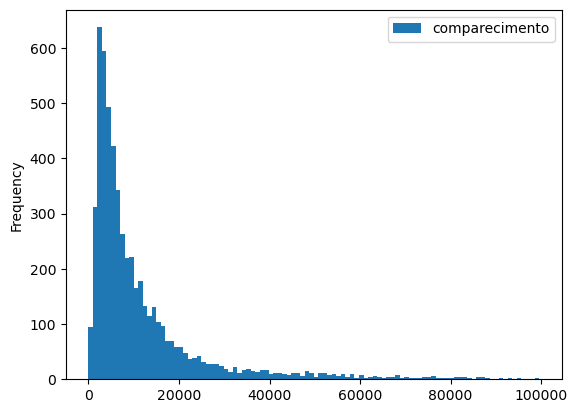

In [9]:
municipios = bdt.groupby('municipio')['qComparecimento'].sum().reset_index(name='comparecimento')
municipios[municipios['comparecimento'] <= 100000].plot.hist(column='comparecimento', bins=100)
printmd(f'O gráfico de distribuição do número de cidades por eleitores que compareceram, mostra um maior número de cidades com aproximadamente até 20 mil comparecimentos nas urnas (lembrando que o número de comparecimento é menor ou igual ao número de eleitores habilitados que, em média, representa 70% do número de habitantes), portanto analisando cidades entre 10 mil e 30 mil comparecimentos, que representariam cidades de 20 a 50 mil habitantes aproximadamente.')

In [10]:
municipios = bdt.groupby('municipio')['qComparecimento'].sum()
municipio_comparecimento = municipios[(municipios > 10000) & (municipios < 30000)]
#bdt[bdt['municipio'].isin(municipio_comparecimento)].groupby('modelUrna')['qComparecimento'].sum().reset_index(name='qtd')

municipio_modelos_urna = bdt[bdt['municipio'].isin(municipio_comparecimento.index)].groupby('modelUrna')['modelUrna'].count()
municipio_total_votos = bdt[bdt['municipio'].isin(municipio_comparecimento.index)].groupby('modelUrna')[['vPresA22', 'vPresB13', 'vPresTotal']].sum()

#calcula o percentual de votos de cada presidente de acoardo com o model de urna
municipio_total_votos['Perc Bolsonaro'] = municipio_total_votos['vPresA22'].div(municipio_total_votos['vPresTotal']).multiply(100).round(2)
municipio_total_votos['Perc Lula'] = municipio_total_votos['vPresB13'].div(municipio_total_votos['vPresTotal']).multiply(100).round(2)

# calcula os votos a favor do candidato Lula
municipio_total_votos['Perc Votos Favor Lula'] = municipio_total_votos['Perc Lula'].div(municipio_total_votos['Perc Bolsonaro']).sub(1).multiply(100).round(2)

tabela_municipio_modelos_urna = pd.concat([municipio_modelos_urna, municipio_total_votos], axis=1)
# modelos_urna.rename(columns={'modelUrna': 'Qtd Urnas', 'vPresTotal': 'Perc Total Votos'}, inplace=True) # renomeia as colunas
tabela_municipio_modelos_urna

,modelUrna,vPresA22,vPresB13,vPresTotal,Perc Bolsonaro,Perc Lula,Perc Votos Favor Lula
modelUrna,,,,,,,
UE2009,12386,1218016,1606590,2824606,43.12,56.88,31.91
UE2010,30119,2872195,4031386,6903581,41.60,58.40,40.38
UE2011,8380,754101,1161583,1915684,39.36,60.64,54.07
UE2013,8218,802524,1069612,1872136,42.87,57.13,33.26
UE2015,21523,2134049,2813618,4947667,43.13,56.87,31.86
UE2020,20406,2202121,2587732,4789853,45.97,54.03,17.53


Constata-se que a distribuição dos modelos de urnas nessas cidades ainda é similar aos planos Regional e Estadual.

Mesmo em cidades pequenas/médias, onde existe menos heterogeneidade e geralmente a maioria dos habitantes do município compartilham de visões políticas muito semelhantes devido ao meio comum que se encontram, **é um fato nítido que as urnas do grupo "UE2020" continuam apresentando o menor percentual favorável ao candidato Lula quando comparado com as urnas do grupo "Não-UE2020", onde o percentual de votos a favor do candidato Lula varia entre 32% e 54%, muito acima do grupo "UE2020" que foi de 17.5%**.

Portando indaga-se às autoridades eleitorais, **como pode em todos as localidades comparadas, Região, Estado, Cidades (pequenas/médias de ideologia política mais homogênea) TODAS as Urnas Eletrônicas do Modelo "Não-UE2020" tem um percentual Bastante SUPERIOR de VANTAGEM de VOTOS ao candidato Lula, nesse caso chegando a até 3.1 vezes maior que as urnas de model "UE2020"?**

Ora, espera-se que uma moeda lançada milhares de vezes dê em média, aproximadamente 50% de Cara ou Coroa, mas se esta moeda, após milhões de lançamentos der um mínimo percentual de 0.1% de diferença (49.95% x 50.05%) já é considerada viciada, então o que dizer de um grupo de Urnas, que nos mesmos grupos analisados, sempre favorecem muito mais um canditado que o outro?

## Estatísticas da Votação e Estados com Segundo Turno para Governador

(em desenvolvimento)